In [60]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [61]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

Found cached dataset mnist (/Users/arun/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|██████████| 2/2 [00:00<00:00, 71.77it/s]


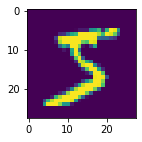

In [62]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [87]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(valid_ds, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [77]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [78]:
# model definition
def linear_classifier():
    return nn.Sequential(
        Reshape((-1, 784)),
        nn.Linear(784, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )

In [79]:
model = linear_classifier()
lr = 0.1
max_lr = 0.1
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)

for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
        if train:
            sched.step()
        accuracy /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")

train, epoch:1, loss: 0.3142, accuracy: 0.7951
eval, epoch:1, loss: 0.2298, accuracy: 0.9048
train, epoch:2, loss: 0.2198, accuracy: 0.9204
eval, epoch:2, loss: 0.1663, accuracy: 0.9350
train, epoch:3, loss: 0.1776, accuracy: 0.9420
eval, epoch:3, loss: 0.1267, accuracy: 0.9493
train, epoch:4, loss: 0.1328, accuracy: 0.9568
eval, epoch:4, loss: 0.0959, accuracy: 0.9598
train, epoch:5, loss: 0.1038, accuracy: 0.9637
eval, epoch:5, loss: 0.0913, accuracy: 0.9643


In [81]:
# with open('./mlp_classifier.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

In [82]:
# def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
#     return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
#                          conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

# class ResBlock(nn.Module):
#     def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
#         super().__init__()
#         self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
#         self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
#         self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
#         self.act = act()

#     def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [83]:
def conv(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, stride=s, padding=ks//2)]
    if norm:
        layers.append(norm)
    if act:
        layers.append(act())
    return nn.Sequential(*layers)

def _conv_block(ni, nf, ks=3, s=2, act=nn.ReLU, norm=None):
    return nn.Sequential(
        conv(ni, nf, ks=ks, s=1, norm=norm, act=act),
        conv(nf, nf, ks=ks, s=s, norm=norm, act=act),
    )

class ResBlock(nn.Module):
    def __init__(self, ni, nf, s=2, ks=3, act=nn.ReLU, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, s=s, ks=ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, s=1, act=None)
        self.pool = fc.noop if s==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()
    
    def forward(self, x):
        return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [92]:
def cnn_classifier():
    return nn.Sequential(
        ResBlock(1, 8, norm=nn.BatchNorm2d(8)),
        ResBlock(8, 16, norm=nn.BatchNorm2d(16)),
        ResBlock(16, 32, norm=nn.BatchNorm2d(32)),
        ResBlock(32, 64, norm=nn.BatchNorm2d(64)),
        ResBlock(64, 64, norm=nn.BatchNorm2d(64)),
        conv(64, 10, act=False),
        nn.Flatten(),
    )


# def cnn_classifier():
#     return nn.Sequential(
#         ResBlock(1, 16, norm=nn.BatchNorm2d(16)),
#         ResBlock(16, 32, norm=nn.BatchNorm2d(32)),
#         ResBlock(32, 64, norm=nn.BatchNorm2d(64)),
#         ResBlock(64, 128, norm=nn.BatchNorm2d(128)),
#         ResBlock(128, 256, norm=nn.BatchNorm2d(256)),
#         ResBlock(256, 256, norm=nn.BatchNorm2d(256)),
#         conv(256, 10, act=False),
#         nn.Flatten(),
#     )

In [93]:
def kaiming_init(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        nn.init.kaiming_normal_(m.weight)        

In [94]:
model = cnn_classifier()
model.apply(kaiming_init)
lr = 0.1
max_lr = 0.3
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)
for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
        if train:
            sched.step()
        accuracy /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")

train, epoch:1, loss: 0.0827, accuracy: 0.9102
eval, epoch:1, loss: 0.0448, accuracy: 0.9817
train, epoch:2, loss: 0.0382, accuracy: 0.9835
eval, epoch:2, loss: 0.0353, accuracy: 0.9863
train, epoch:3, loss: 0.0499, accuracy: 0.9856
eval, epoch:3, loss: 0.0300, accuracy: 0.9867
train, epoch:4, loss: 0.0361, accuracy: 0.9869
eval, epoch:4, loss: 0.0203, accuracy: 0.9877
train, epoch:5, loss: 0.0427, accuracy: 0.9846
eval, epoch:5, loss: 0.0250, accuracy: 0.9866


In [95]:
# with open('./cnn_classifier.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

#### commit to .py file for deployment

In [96]:
!jupyter nbconvert --to script --TagRemovePreprocessor.remove_cell_tags="exclude" --TemplateExporter.exclude_input_prompt=True mnist_classifier.ipynb


[NbConvertApp] Converting notebook mnist_classifier.ipynb to script
[NbConvertApp] Writing 5934 bytes to mnist_classifier.py
